# Базы данных

Реляционные базы данных представляют из себя таблицы, которые соединены между собой.

В каждой таблице есть первичный ключ (Primary key - PK). Обычно он включает в себя id строки.

Если мы хотим соединить две таблицы, то можно сделать это при помощи внешнего ключа (Foreign key - FK).

## Нормальные формы

Большие таблицы (в которых много столбцов) принято разбивать на несколько маленьких.

Например, если в таблице есть колонки "имя пользователя", "дата+время сообщения", "текст сообщения", то лучше вынести имена пользователя в отдельную таблицу.

Если этого не сделать, то при изменении/удалении существующих сообщений мы можем случайно удалить лишнюю информацию.

Есть формальные правила, которые определяют как нужно разбивать таблицы, чтобы было меньше проблем при работе с ними. 

Правила называются нормальными формами, всего их 6 (8), но обычно достаточно первых трех. [Почитать подробнее можно здесь.](https://habr.com/ru/post/254773/)

## Типы связей

Таблицы могут быть связаны между собой следующими видами связей:

- one-to-many - когда одной строке таблицы соответствует много записей в другой. Например, "пользователь" и "комментарий" - пользователь может оставить много комментариев, но у комментария может быть только один автор.
- many-to-many - когда многим записям таблицы соответствует много записей в другой. Например, "пользователь" и "сообщество" - пользователь может вступать во много сообществ, и у сообщества может быть много пользователей.

## Пример схемы БД:

![db example](../images/db_example.png)

## Вопросы

- Какой тип связи между User и Message?
- Какой тип связи между Chat и Message?
- Какой тип связи между User и Chat?
- Как бы можно было реализовать закрепление сообщений на этой схеме?

## Как взаимодействовать с базой?

Обычно это делают при помощи SQL (Structured Query Language) - специального языка запросов. [Прочитать введение в SQL можно тут.](https://proglib.io/p/sql-for-20-minutes)

Запрос на языке SQL обрабатывается системой управления базой данных и возвращает в ответ таблицу с нужными данными. 

Мы будем писать простые запросы на SQL и отдавать их pandas, который за нас будет общаться с базой данных.

## Про ORM

Обычно для работы с БД подключают специальные библиотеки, которые позволяют в коде описывать схему базы данных и из кода ей управлять. 

Такие библиотеки называются ORM (object-relational-mapping) и они позволяют удобно работать со строками таблицы как с объектами в коде.

Для наших целей это не понадобится, поэтому просто оставлю ссылку на самую популярную ORM в Python: [SQLAlchemy](https://www.sqlalchemy.org/)

## Про СУБД

Мы будем пользоваться SQLite, так как она установлена в стандартной библиотеке питона и ее проще всего использовать.

Также существуют другие СУБД, которые более безопасны, быстрее работают и имеют больше функций:

- PostgreSQL
- MySQL
- MariaDB
- Oracle
- Microsoft SQL Server

Но SQLite не бесполезен, его часто используют для разработки. А также принцип работы со всеми СУБД один и тот же, поэтому научившись работать с SQLite будет гораздо проще работать с остальными СУБД

In [1]:
import pandas as pd
import sqlite3

Создадим две таблицы - с предметами и учителями

In [2]:
sql = sqlite3.connect('../data/school.db')

In [3]:
subjects = ["English", "Math", "IT", "Literature"]
subject_df = pd.DataFrame({'name': subjects})
subject_df

,name
0,English
1,Math
2,IT
3,Literature


In [4]:
subject_df.to_sql('subjects', sql, index_label="id", if_exists='replace') # Сохраним в базу
pd.read_sql("SELECT * FROM subjects", sql) # Проверим, что сохранилось правильно

,id,name
0,0,English
1,1,Math
2,2,IT
3,3,Literature


In [5]:
names = ["Alice", "Bob", "Charlie", "Denis", "Emilie"]
ages = [20, 25, 35, 30, 45]
teachers_df = pd.DataFrame({'name': names, 'age': ages})
teachers_df

,name,age
0,Alice,20
1,Bob,25
2,Charlie,35
3,Denis,30
4,Emilie,45


In [6]:
teachers_df.to_sql('teachers', sql, index_label="id", if_exists="replace")
pd.read_sql("SELECT * FROM teachers", sql)

,id,name,age
0,0,Alice,20
1,1,Bob,25
2,2,Charlie,35
3,3,Denis,30
4,4,Emilie,45


Как друг к другу относятся учителя и предметы?

- 1-to-1
- 1-to-many
- many-to-many

In [68]:
teacher_id = [0, 1, 2, 3, 4, 0, 2]
subject_id = [3, 2, 2, 1, 3, 2, 0]

teachers_to_subjects_df = pd.DataFrame({'teacher_id': teacher_id, 'subject_id': subject_id})
teachers_to_subjects_df

,teacher_id,subject_id
0,0,3
1,1,2
2,2,2
3,3,1
4,4,3
5,0,2
6,2,0


In [74]:
teachers_to_subjects_df.to_sql("teachers_to_subjects", sql, index_label="id", if_exists="replace")

In [9]:
pd.read_sql("SELECT * FROM teachers_to_subjects", sql)

,id,teacher_id,subject_id
0,0,0,3
1,1,1,2
2,2,2,2
3,3,3,1
4,4,4,3
5,5,0,2


Объединим таблицы при помощи SQL

In [10]:
pd.read_sql(
    """
    SELECT teachers_to_subjects.id as id,
    subjects.name as subject_name, 
    teachers.name as teacher_name,
    teachers_to_subjects.teacher_id as teacher_id,
    teachers_to_subjects.subject_id as subject_id
    FROM teachers_to_subjects 
    JOIN subjects ON teachers_to_subjects.subject_id = subjects.id
    JOIN teachers ON teachers_to_subjects.teacher_id = teachers.id
    """,
    sql)

,id,subject_name,teacher_name,teacher_id,subject_id
0,0,Literature,Alice,0,3
1,1,IT,Bob,1,2
2,2,IT,Charlie,2,2
3,3,Math,Denis,3,1
4,4,Literature,Emilie,4,3
5,5,IT,Alice,0,2


Сделаем тоже самое при помощи pandas

In [11]:
teachers_to_subjects_df.set_index("teacher_id").join(teachers_df).set_index("subject_id").join(subject_df, rsuffix='_subject', lsuffix='_teacher').reset_index(drop=True)

,name_teacher,age,name_subject
0,Denis,30,Math
1,Alice,20,IT
2,Bob,25,IT
3,Charlie,35,IT
4,Alice,20,Literature
5,Emilie,45,Literature


In [12]:
teachers_to_subjects_df.join(teachers_df, on='teacher_id').join(subject_df, on='subject_id', rsuffix='_subject', lsuffix='_teacher')

,teacher_id,subject_id,name_teacher,age,name_subject
0,0,3,Alice,20,Literature
1,1,2,Bob,25,IT
2,2,2,Charlie,35,IT
3,3,1,Denis,30,Math
4,4,3,Emilie,45,Literature
5,0,2,Alice,20,IT


## Задание 1

Добавить таблицу "students" и "groups", зачислить в студентов в группы, связав внешним ключом.

Данные для таблиц задавать вручную.

In [13]:
# Ваш код здесь
groups = ["2411", "2412", "2431"]
groups_df = pd.DataFrame({'name' : groups})
groups_df.to_sql("groups", sql, index_label="id", if_exists="replace")

students = ["Ivanov", "Petrov", "Sidorov", "Kozlov"]
stud_grp = [0, 1, 1, 2]
students_df = pd.DataFrame({'name' : students, 'group_id' : stud_grp})
students_df.to_sql("students", sql, index_label="id", if_exists="replace")

pd.read_sql("select s.name, g.name from students s left join groups g on g.id = s.group_id", sql)

,name,name
0,Ivanov,2411
1,Petrov,2412
2,Sidorov,2412
3,Kozlov,2431


## Задание 2

Добавить таблицу "marks"

Посчитать средний балл всех студентов

Посчитать среднюю оценку каждого студента по всем предметам

In [14]:
import numpy as np
# Ваш код здесь
mark_student =  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
mark_subject = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
mark_val =      np.random.randint(1,5,16)
marks_df = pd.DataFrame({'student_id' : mark_student, 'subject_id' : mark_subject, 'mark' : mark_val})
marks_df.to_sql("marks", sql, index_label="id", if_exists="replace")

In [15]:
marks_df.describe()

,student_id,subject_id,mark
count,16.000000,16.000000,16.000000
mean,1.500000,1.500000,2.500000
std,1.154701,1.154701,1.154701
min,0.000000,0.000000,1.000000
25%,0.750000,0.750000,1.750000
50%,1.500000,1.500000,2.500000
75%,2.250000,2.250000,3.250000
max,3.000000,3.000000,4.000000


In [16]:
pd.read_sql("select avg(m.mark) from marks m", sql)

,avg(m.mark)
0,2.5


In [17]:
pd.read_sql("select s.name, avg(m.mark) from marks m left join students s on s.id = m.student_id group by m.student_id", sql)

,name,avg(m.mark)
0,Ivanov,2.50
1,Petrov,2.50
2,Sidorov,1.75
3,Kozlov,3.25


In [18]:
pd.read_sql("select s.name, avg(m.mark) from marks m left join subjects s on s.id = m.subject_id group by m.student_id", sql)

,name,avg(m.mark)
0,Literature,2.50
1,Literature,2.50
2,Literature,1.75
3,Literature,3.25


## Задание 3

Сгенерировать данные для таблиц (фунция `np.random.randint`)

In [19]:
# Ваш код здесь
mark_student =  [i%4 for i in range(4*60)]
mark_subject = [i%4 for i in range(4*60)]
mark_val =      np.random.randint(1,6,4*60)
#print(len(mark_student), len(mark_subject), len(mark_val))
marks_df = pd.DataFrame({'student_id' : mark_student, 'subject_id' : mark_subject, 'mark' : mark_val})
marks_df.to_sql("marks", sql, index_label="id", if_exists="replace")
marks_df.describe()

,student_id,subject_id,mark
count,240.000000,240.000000,240.000000
mean,1.500000,1.500000,2.979167
std,1.120371,1.120371,1.342725
min,0.000000,0.000000,1.000000
25%,0.750000,0.750000,2.000000
50%,1.500000,1.500000,3.000000
75%,2.250000,2.250000,4.000000
max,3.000000,3.000000,5.000000


## Задание 4

Добавить таблицу "lessons", установить какая группа в какие дни занималась

Изменить таблицу "marks", связав ее с датой проведения занятия

In [78]:
# Ваш код здесь
from datetime import date, timedelta

sdate = date(2022,2,4);
edate = date(2022,3,19);
lesson_date = pd.date_range(sdate,edate-timedelta(days=1), freq='d')
lesson_df = pd.DataFrame({'lesson_date' : lesson_date})
lesson_df.to_sql('lessons', sql, index_label="id", if_exists='replace')

# Ваш код здесь
mark_student =  [i%4 for i in range(4*60)]
mark_subject = [i%4 for i in range(4*60)]
mark_val =      np.random.randint(1,6,4*60)
mark_lesson = [np.random.randint(1,42,1)[0] for i in range(4*60)]

marks_df = pd.DataFrame({'student_id' : mark_student, 'subject_id' : mark_subject, 'mark' : mark_val, 'lesson_id' : mark_lesson})
marks_df.to_sql("marks", sql, index_label="id", if_exists="replace")

## Задание 5

Построить график успеваемости для каждой группы для заданного предмета за заданный период времени

In [44]:
import matplotlib.pyplot as plt

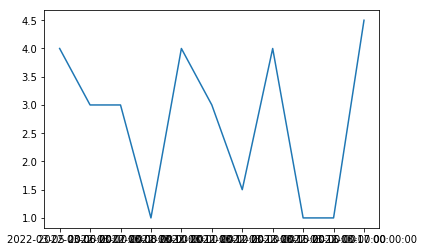

In [79]:
# Ваш код здесь
success_df = pd.read_sql(
    """select 
            l.lesson_date, 
            g.name as group_name,
            avg(m.mark) as mark
        from marks m 
        left join lessons l on m.lesson_id = l.id 
        left join students s on m.student_id = s.id
        left join groups g on s.group_id = g.id
        where m.subject_id = :subject and l.lesson_date >= :start_date and l.lesson_date <= :end_date
        group by l.lesson_date, g.id
        """, sql, params={'subject': 2, 'start_date': date(2022,3,4), 'end_date' : date(2022,3,18)})
plt.plot(success_df["lesson_date"], success_df["mark"])

## Задание 6

Найти преподавателя с наименьшим средним баллом по его предметам

In [76]:
# Ваш код здесь
teacher_avg_df = pd.read_sql(
    """select
            t.name,
            avg(m.mark) as mark
        from marks m 
        left join lessons l on m.lesson_id = l.id 
        left join teachers_to_subjects ts on ts.subject_id = m.subject_id
        left join teachers t on t.id = ts.teacher_id
        group by t.id
        order by avg(m.mark) asc
        """, sql)
teacher_avg_df

,name,mark
0,Denis,2.650000
1,Bob,2.933333
2,Charlie,3.008333
3,Alice,3.091667
4,Emilie,3.250000


# Домашняя работа

Нужно придумать небольшую базу данных и написать к ней запросы.

В базе должно быть минимум 4 таблицы и хотя бы две связи вида one-to-many или many-to-many. Можно решить как при помощи pandas, так и при помощи SQL.

Запросы должны быть осмысленными и должны решать какую-то задачу.

## Easy

Выгрузить данные и отфильтровать их по какому-то значению.

Пример запроса с БД, приведенной выше: вывести учителей старше 30 лет.

## Normal

Написать запрос на объединение двух или более таблиц, также в запросе должна быть фильтрация

Пример запроса с БД, приведенной выше: найти имя учителя моложе 30 лет, который ведет математику

## Hard

Написать запрос, который посчитает какую-то сложную аналитику по БД, используя как можно больше таблиц. Построить графики и сделать выводы.

Пример запроса с БД, приведеной выше: задание 5.

# Полезные ссылки

- [SQLAlchemy](https://www.sqlalchemy.org/)
- [Нормальные формы](https://habr.com/ru/post/254773/)
- [SQLite DB Browser](https://sqlitebrowser.org/) - чтобы просматривать базу данных
- [vscode-database](https://marketplace.visualstudio.com/items?itemName=bajdzis.vscode-database) - расширение для VS Code для просмотра баз данных